In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py
import scipy

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(2)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.35:51902 Dashboard: http://10.148.0.35:8787/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GB


---


# 1. LLC results

In [4]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


_________
# 2. Drifter Results

In [5]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v),                           157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [7]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [8]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [9]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [10]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...

 data size: 3.6 GB


In [11]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60, 61, 1), labels=np.arange(-59.5, 60.5, 1)).mean(dim=['lat']))
E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
print(E_drifter_linear_window)

<xarray.DataArray 'E_drifter_linear_window' (lat_bins: 120, freq_time: 1440)>
array([[1717.545467, 5195.858884, 5435.309011, ..., 4318.254987, 4872.804495,
        4362.969694],
       [2117.836486, 5932.966952, 6664.371628, ..., 6106.415228, 6836.875017,
        6148.201417],
       [2539.646973, 6478.462956, 6424.355864, ..., 6469.237198, 6885.777719,
        5899.57606 ],
       ...,
       [1277.64775 , 3729.830322, 3838.471638, ..., 2699.119365, 2751.959996,
        2644.010506],
       [1277.114179, 3812.252713, 3776.36598 , ..., 2684.465139, 3330.944442,
        2866.258309],
       [1234.748443, 3624.093405, 3400.288399, ..., 2362.644358, 2587.16606 ,
        2747.094201]])
Coordinates:
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


_________
# 3. Interp

In [12]:
E_drifter_interp = E_drifter_linear_window.interp(lat_bins = E.lat,freq_time= E.freq_time)
E_drifter_interp

<xarray.DataArray 'E_drifter_linear_window' (lat: 120, freq_time: 1439)>
array([[7.762304, 7.89604 , 7.948986, ..., 7.085611, 6.683111, 7.230941],
       [7.60821 , 7.016882, 6.731199, ..., 8.214426, 7.857167, 7.713882],
       [7.721452, 7.957637, 7.779369, ..., 7.673507, 7.921026, 7.788044],
       ...,
       [6.020134, 6.474917, 6.338495, ..., 6.027712, 5.724436, 5.529201],
       [5.194825, 5.109022, 5.414441, ..., 4.439066, 4.768291, 4.725191],
       [3.715913, 3.200968, 3.679331, ..., 4.776466, 4.290979, 4.395799]])
Coordinates:
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 -11.99 -11.98 -11.96 -11.94 ...
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 ...
  * freq_time          (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 ...

_________
# 4. Ratio

In [15]:
E_ratio = E/E_drifter_interp
E_ratio = E_ratio.assign_coords(freq_cpd=E_ratio.freq_time * 86400.) 
E_ratio = E_ratio.chunk({'freq_time': 1439, 'lat': 1})
E_ratio                     

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(1, 1439)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 ...
    freq_time_spacing  float64 1.929e-07
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 ...
    freq_cpd           (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>

In [16]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
E_ratio = np.real(E_ratio).rename('E_ratio')
file_E = data_dir+'E_ratio.zarr'
%time E_ratio.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 764 ms, sys: 76 ms, total: 840 ms
Wall time: 9.14 s


______

# Read Ratio

In [6]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
E_ratio = xr.open_zarr(data_dir+'E_ratio.zarr').chunk({'freq_time': 1439, 'lat': 1}) 
E_ratio = E_ratio.E_ratio
E_ratio

<xarray.DataArray 'E_ratio' (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(1, 1439)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
  * freq_time          (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
    freq_time_spacing  float64 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 ...
    lat_bins           (lat) float64 dask.array<shape=(120,), chunksize=(1,)>

In [7]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


# Plots

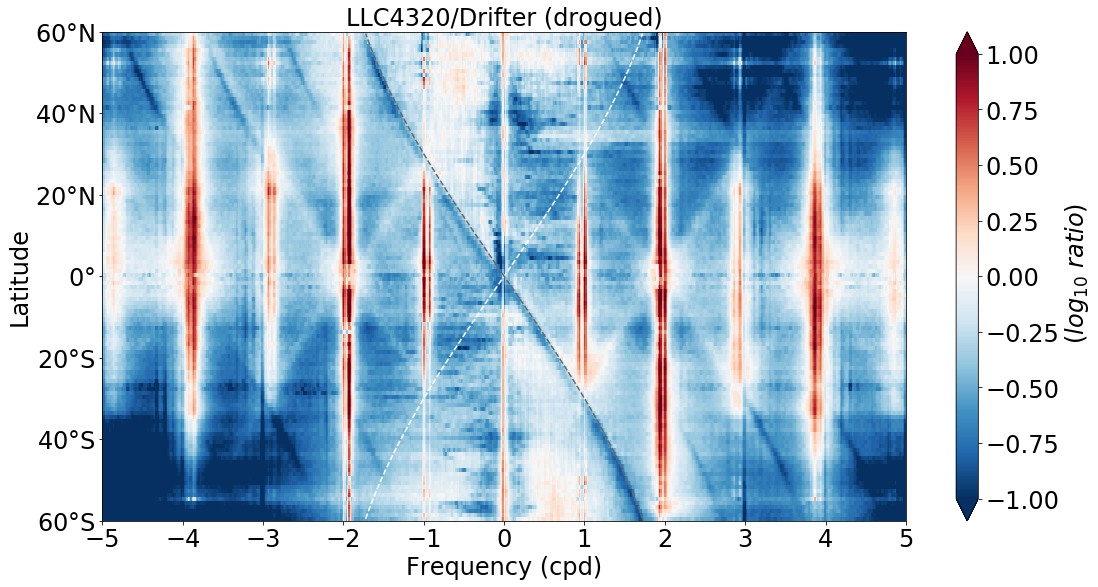

In [14]:
font_size = 24

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

cax = np.log10(E_ratio).plot.pcolormesh(ax=ax, vmin=-1., vmax=1., x='freq_cpd', y='lat', cmap = 'RdBu_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label(' ($log_{10}\ ratio)$', fontsize=24)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])


ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat,'--',color='dimgrey')
ax.set_title('LLC4320/Drifter (drogued)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifer_ratio.png')



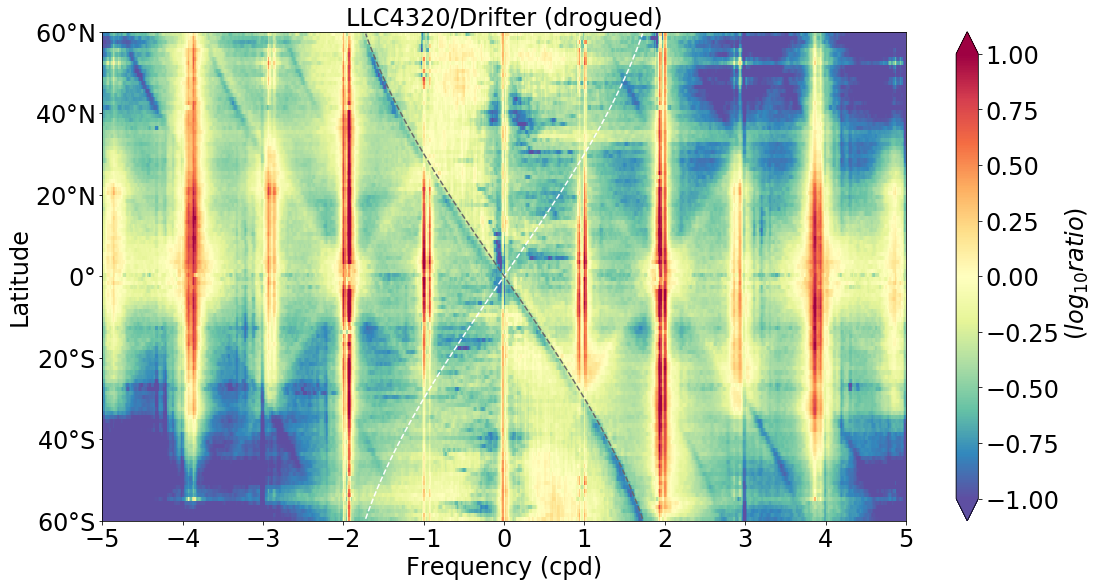

In [30]:
font_size = 24

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

cax = np.log10(E_ratio).plot.pcolormesh(ax=ax, vmin=-1., vmax=1., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label(' ($log_{10} ratio)$', fontsize=24)
            
# x,y ticks
#ax.set_xticks([-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])


ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat,'--',color='dimgrey')
ax.set_title('LLC4320/Drifter (drogued)',fontsize=font_size)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifer_ratio.png')


Text(0.5,1,'LLC4320/Drifter (drogued)')

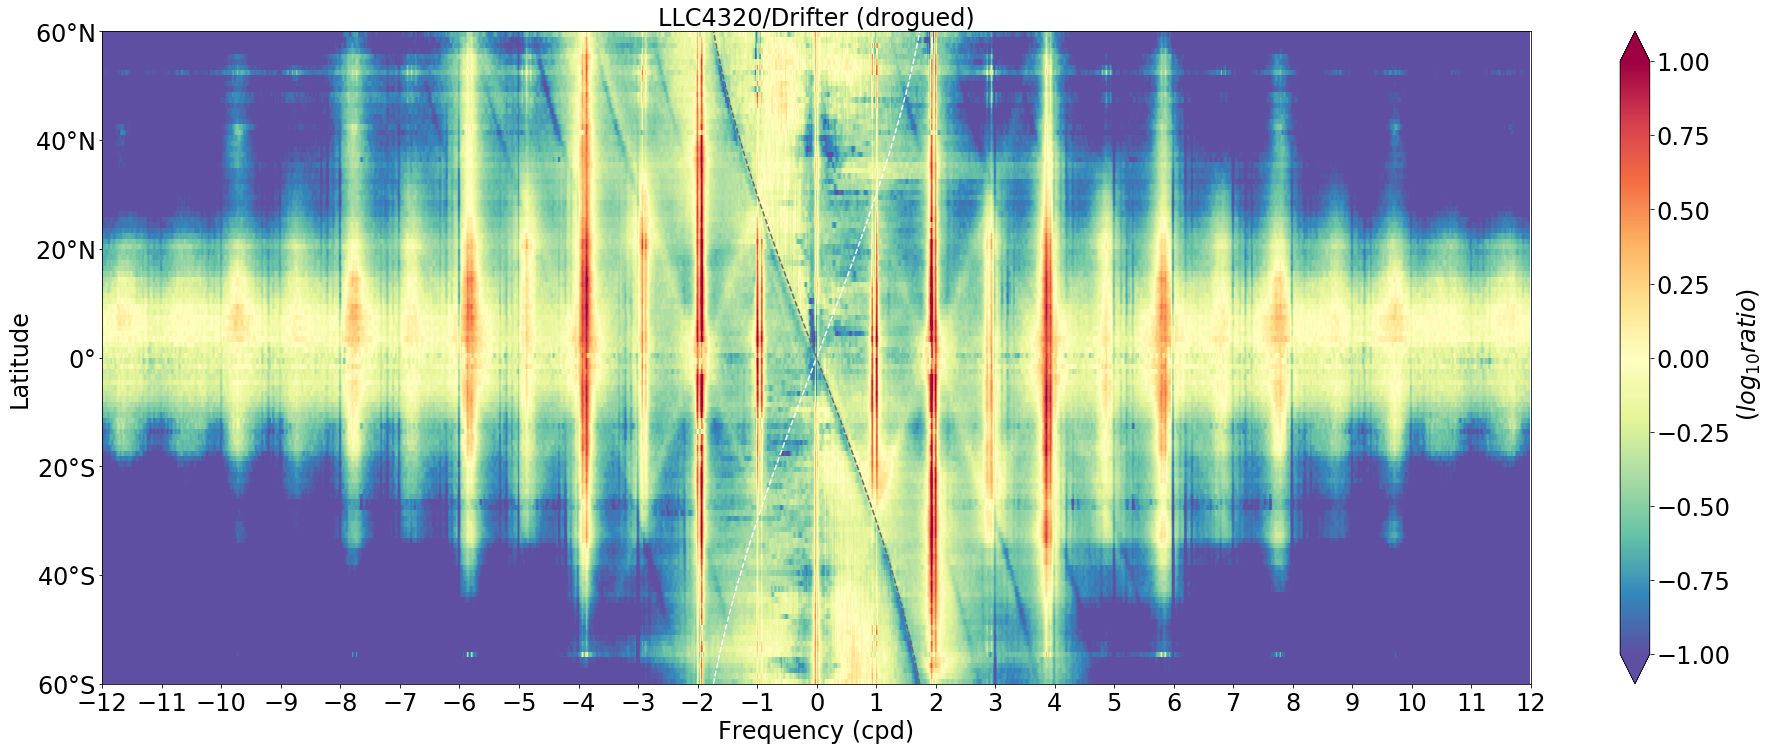

In [30]:
font_size = 24

plt.figure(figsize=(32,12))
ax = plt.subplot(1,1,1)

cax = np.log10(E_ratio).plot.pcolormesh(ax=ax, vmin=-1., vmax=1., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label(' ($log_{10} ratio)$', fontsize=24)
            
# x,y ticks
ax.set_xticks([-12., -11., -10., -9., -8., -7., -6., -5., -4., -3., -2., -1., 0, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])


ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('LLC4320/Drifter (drogued)',fontsize=font_size)


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison_22.png')


In [16]:
cluster.scheduler.close()

<Future finished result=None>